# 2 практическое задание. Сегментация изображений.

## Практикум на ЭВМ для 317 группы, весна 2020

#### Фамилия, имя: 

Дата выдачи: 8 марта

Мягкий дедлайн: 22 марта 23:59 

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур Unet и Linknet.

## Загрузка данных (1 балл)

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с imagenet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс PhotosDataset для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
ls

gdrive/  sample_data/


In [ ]:
! cp /content/gdrive/My\ Drive/test.zip .
! unzip -q test.zip
! rm test.zip 
! ls 

gdrive	sample_data  test


In [ ]:
! cp /content/gdrive/My\ Drive/train.zip . 
! unzip -q train.zip
! rm train.zip 
! ls

gdrive	sample_data  test  train


In [ ]:
! cp /content/gdrive/My\ Drive/test_mask.zip . 
! unzip -q test_mask.zip
! rm test_mask.zip 
! ls 

gdrive	sample_data  test  test_mask  train


In [ ]:
! cp /content/gdrive/My\ Drive/train_mask.zip .
! unzip -q train_mask.zip
! rm train_mask.zip 
! ls 

gdrive	sample_data  test  test_mask  train  train_mask


In [ ]:
! cp /content/gdrive/My\ Drive/back.zip .
! unzip -q back.zip
! rm back.zip 
! ls 

back  gdrive  sample_data  test  test_mask  train  train_mask


In [ ]:
import torch
import torch.nn as nn
import torchvision

import random

import numbers

import numpy as np
import numpy.testing as npt

from torch.utils.data.dataset import Dataset
from PIL import Image
from os.path import join

import os

from skimage.io import imread
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

from torch.utils.data import DataLoader
from torch.nn import BCEWithLogitsLoss

import torch.optim as optim
from torchvision.models import vgg13
import torch.cuda

from IPython import display
import time

In [ ]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, images_name, target_dir=None, transforms=None, train=False):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        images_names : list of str
            Images short names
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        # your code here
        
        self.images_dir = images_dir
        self.images_name = images_name
        self.target_dir = target_dir
        self.transforms = transforms
        self.len = len(self.images_name)
        self.train = train
        
    def __len__(self):
        # your code here
        return self.len
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        # your code here
        
        if idx >= self.len: # как-то обработать случай выхода за границы
            raise IndexError
            
        if not isinstance(idx, int):
            raise TypeError
    
        name = self.images_name[idx]
        image = Image.open(join(self.images_dir, name))
        
        mask_name = self.images_name[idx][:len(name) - 4] + '.png'
        mask  = Image.open(join(self.target_dir, mask_name))
        
        param = random.randint(0, 4)

        if self.train:
          for i in range(3):
              obj = self.transforms[i]()
              image, mask = obj(image, mask)
          
          obj = self.transforms[3](back[param])
          image, mask = obj(image, mask)
          
        image = self.transforms[4](image)
        mask = self.transforms[4](mask)
        
        image = self.transforms[5](image)
        #mask = self.transforms[5](mask)
        mask[mask == 255] = 1

        return (image, mask)

In [ ]:
back = []
back.append(Image.open('back/back_1.jpg'))
back.append(Image.open('back/back_2.jpg'))
back.append(Image.open('back/back_3.jpg'))
back.append(Image.open('back/back_4.jpg'))
back.append(Image.open('back/back_5.jpg'))

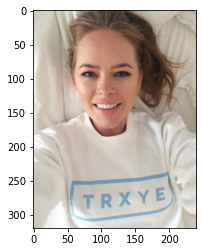

In [ ]:
img = Image.open('train/1.jpg')
plt.imshow(img)

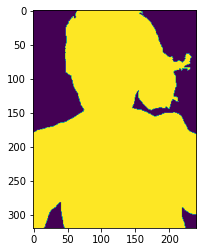

In [ ]:
img1 = Image.open('train_mask/1.png')
plt.imshow(img1)

## Модуль аугментации (3 балла)

Конструктор стандартного `ImageFolder`, принимают параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в http://pytorch.org/docs/master/torchvision/transforms.html.

В данной части вам предлагается самостояльно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

* случайное (с вероятностью p) горизонтальное отображение (flip) изображения + маска
* случайное (с веротностью p) вырезание фрагмента изображения (заданного или случайного размера) + маска
* случайное (с вероятностью p) изменение яркости изображения (на заданную или случайную величину) - маска
* случайное (с веротностью p) изменение фона изображения (на изображение из заданного списка изображений) - маска

In [ ]:
def apply_to_mask(*params):
    def inner_dec(func):
        def wrapper(self, img, mask=None, *args):
            if params[0]:
                return func(self, img, mask), func(self, mask, mask)
            else:
                return func(self, img, mask), mask
            return func(*args, **kwargs)
        wrapper.__module__ = func.__module__
        wrapper.__name__ = func.__name__
        wrapper.__doc__ = func.__doc__
        return wrapper
    return inner_dec

In [ ]:
def make_probable(*params):
    def inner_dec(func):
        def wrapper(self, *args, **kwargs):
            if random.random() < params[0]:
                p = 1
            else:
                p = 0
            return func(self, *args, **kwargs, p=p)
        wrapper.__module__ = func.__module__
        wrapper.__name__ = func.__name__
        wrapper.__doc__ = func.__doc__
        return wrapper
    return inner_dec

In [ ]:
alpha = True
beta = 0.5

In [ ]:
alpha = True
beta = 0.5
# Просят горизонтальное отображение, однако в условиях задачи логичнее было бы применять вертикальное, как и в примере формулировки задания выше
class HorizontalFlip(object):
    @make_probable(beta)
    def __init__(self, p=1):
        self.p = p
    
    @apply_to_mask(alpha)
    def __call__(self, img, mask=None):
        if self.p:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

In [ ]:
obj = HorizontalFlip()
a, b = obj(img, img1)

In [ ]:
alpha = True
beta = 0.5
class ImageCrop(object):
    @make_probable(beta)
    def __init__(self, size=None, p=1):
        self.p = p
        if size is None:
            self.size = (random.randint(120, 200), random.randint(120, 200))
        elif isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
            
    @apply_to_mask(alpha)
    def __call__(self, img, mask=None):
        if random.random() < self.p:
            width, height = img.size   # Get dimensions
            new_width, new_height = self.size

            left = (width - new_width)/2
            top = (height - new_height)/2
            right = (width + new_width)/2
            bottom = (height + new_height)/2

            res = img.crop((left, top, right, bottom))
            
            return Image.fromarray(np.uint8(res)).resize(img.size)
        return img

In [ ]:
obj = ImageCrop()
a, b = obj(img, img1)

In [ ]:
alpha = False
beta = 0.5
class ChangeBrightness(object):
    @make_probable(beta)
    def __init__(self, p=1):
        self.p = p
    
    @apply_to_mask(alpha)
    def __call__(self, img, mask=None):
        if random.random() < self.p:
            level = random.random() + 0.5
            def brightness(img):
                return img * level
            return img.point(brightness)
        return img

In [ ]:
obj = ChangeBrightness()
a, b = obj(img, img1)

In [ ]:
alpha = False
beta = 0.5
class ChangeBack(object):
    @make_probable(beta)
    def __init__(self, back, p=1):
        self.p = p
        self.back = back
        
    @apply_to_mask(alpha)
    def __call__(self, img, mask):
        if random.random() < self.p:
            mask = np.array(mask)
            mask[np.where(mask == 255)] = 1
            img_without_back = np.array(img) * mask[..., np.newaxis]
            new_mask = (~mask.astype(bool)).astype(int)
            back = np.array(self.back) * new_mask[..., np.newaxis]
            res = img_without_back + back
            return Image.fromarray(np.uint8(res))
        return img

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```
transforms.ToTensor()
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
```

In [ ]:
param = random.randint(0, 4)
lst_transform = [HorizontalFlip, ImageCrop, ChangeBrightness, ChangeBack, transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])]

In [ ]:
DATA_PATH = ''
train_images = os.listdir('train')
test_images = os.listdir('test')


train_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    images_name=train_images,
    target_dir=DATA_PATH + 'train_mask/',
    transforms=lst_transform,
    train=True # флаг, чтобы преобразования применялись только к объектам трейна
)

test_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'test/',
    images_name=test_images,
    target_dir=DATA_PATH + 'test_mask/',
    transforms=lst_transform,
    train=False
)

Функция для отображения изображения:

In [ ]:
def show_idx_image(dataset, idx):
    mask_img = dataset[idx]

    image_to_show = mask_img[0].transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    mask_to_show = mask_img[1][0].numpy()

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(7)
    fig.set_figheight(3)


    plt.subplot(1, 2, 1)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_to_show)
    plt.axis('off')

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

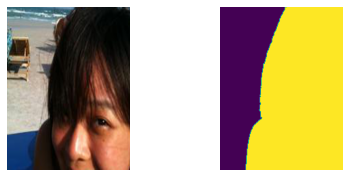

In [ ]:
show_idx_image(train_dataset, 10) # обрезка + поворот

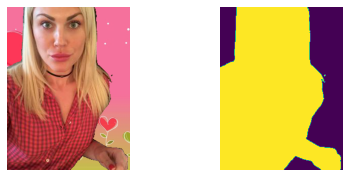

In [ ]:
show_idx_image(train_dataset, 14) # смена фона + поворот

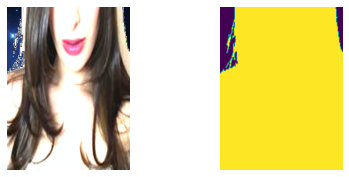

In [ ]:
show_idx_image(train_dataset, 20) # обрезка + смена фона

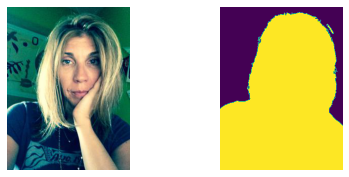

In [ ]:
show_idx_image(test_dataset, 1) # изображения тестовой выборки сохранены без изменений

## Загрузчики

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры DataLoader. При num_workers > 1, батчи готовятся (загружаются картинки, обрабатываются и т.д.) сразу в нескольких фоновых процессах. С помощью параметра shuffle можно подавать картинки на обучение в случайном порядке.

In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=8)

## DiceLoss (1 балл)

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через nn.Module. В ячейке ниже вам предлагается реализовать фукцию потерь dice (аналог меры Джаккарда).

Результат dice loss определим как:

$$
1 - \frac{2\sum_{i, j}a_{ij}b_{ij}}{\sum_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — разметка для пикселя изображения.

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7, reduction='none', with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : string ('none', 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            'none': no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        #true_labels = true_labels.long()
        
        if self.with_logits:
            logits = torch.sigmoid(logits)

        # your code here
        
        loss = 1 - 2 * torch.sum(torch.mul(logits, true_labels), dim=[1, 2]) / (torch.sum(logits + true_labels + self.eps, dim=[1, 2]))
        
        if self.reduction == 'sum':
            loss_value = loss.sum()# your code
        elif self.reduction == 'mean':
            loss_value = loss.mean()# your code
        else:
            loss_value = loss # your code
            
        return loss_value

Проверка реализации:

In [ ]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
], dtype=torch.float32)

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## Unet (2 балла)

Для решения задачи сегментации будем использовать UNet с энкодером из первых блоков предобученного VGG13. Архитектура сети реализована за вас ниже.

Энкодер:

In [ ]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        feature_extractor = vgg13(pretrained=pretrained).features
        for i in range(self.num_blocks):
            self.blocks.append(
                torch.nn.Sequential(*[feature_extractor[j]
                                      for j in range(i * 5, i * 5 + 4)]))

    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
            activations.append(x)
            if i != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations

Декодер:

In [ ]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )

    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.conv1(torch.cat([left, x], 1))
        x = self.conv2(x)
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

Сеть Unet:

In [ ]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Функция для оценивания качества сети:

In [ ]:
def evaluate_net(net, testloader, criterion, val_criterion, device='cuda'):
    net = net.eval()

    loss = 0.
    correct = 0.
    total = 0.
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            labels = labels.to(device)

            images = images.to(device)
            
            outputs = net(images).to('cuda')
            total += labels.size(0)
            loss += float(criterion(outputs, labels).detach())
            correct += float(val_criterion(outputs, labels).detach())
    
    mean_loss = loss / total
    metric = correct / total
    
    return mean_loss, metric

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке.

Сначала при обучении используйте только кросс-энтропию (torch.nn.BCEWithLogitsLoss будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации (только кросс-энтропия, только dice loss, сумма двух лоссов с весами). Сделайте выводы.

In [ ]:
net = UNet()
if torch.cuda.is_available():
    net.cuda()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
criterion = BCEWithLogitsLoss()

In [ ]:
def optimize_net(n_epochs, net, trainloader, optimizer, criterion, test_criterion, test_val_criterion,
                 use_cuda=True, verbose=True, batch_verbose_proportion=0.5):
    net = net.train()
    
    n_batches = len(trainloader)
    n_batches_for_verbose = int(n_batches * batch_verbose_proportion)    
    
    # loop over the dataset multiple times
    start = time.time()

    for epoch in range(n_epochs):  
        print('n_epoch:', epoch, 'time:', time.time() - start)
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += float(loss)

            # print every 6000 mini-batches
            if verbose:
                if i % n_batches_for_verbose == n_batches_for_verbose - 1:
                    epoch_value = np.around(i / n_batches, 2)
                    print(
                        '[{:.2f}] loss: {:.3f}'
                        .format(epoch_value, running_loss / n_batches_for_verbose)
                    )
                    running_loss = 0.0
                    
                
        if verbose:
            test_loss, test_accuracy = evaluate_net(net, test_data_loader,  test_criterion, test_val_criterion)
            print(
                '[{}] test_loss_1: {:.3f}, test_loss_2: {:.3f}'
                .format(epoch + 1, test_accuracy, test_loss)
            )
            print('------------------------------')
    
    if verbose:
        print('Finished Training')

In [ ]:
optimize_net(30, net, train_data_loader, optimizer, criterion)

n_epoch: 0
[0.49] loss: 0.276
[0.99] loss: 0.225
[1] test_loss_1: 0.049, test_loss_2: 0.042
------------------------------
n_epoch: 1
[0.49] loss: 0.202
[0.99] loss: 0.191
[2] test_loss_1: 0.049, test_loss_2: 0.034
------------------------------
n_epoch: 2
[0.49] loss: 0.176
[0.99] loss: 0.181
[3] test_loss_1: 0.049, test_loss_2: 0.035
------------------------------
n_epoch: 3
[0.49] loss: 0.172
[0.99] loss: 0.170
[4] test_loss_1: 0.048, test_loss_2: 0.039
------------------------------
n_epoch: 4
[0.49] loss: 0.161
[0.99] loss: 0.168
[5] test_loss_1: 0.049, test_loss_2: 0.031
------------------------------
n_epoch: 5
[0.49] loss: 0.159
[0.99] loss: 0.150
[6] test_loss_1: 0.048, test_loss_2: 0.031
------------------------------
n_epoch: 6
[0.49] loss: 0.146
[0.99] loss: 0.156
[7] test_loss_1: 0.048, test_loss_2: 0.039
------------------------------
n_epoch: 7
[0.49] loss: 0.158
[0.99] loss: 0.143
[8] test_loss_1: 0.048, test_loss_2: 0.031
------------------------------
n_epoch: 8
[0.49

В связи с возможными ошибками в функции evaluate_net (при использовании метода sum в лocce значение функции потерь доходит до нескольких тысяч), а также из-за сильной аугментации данных обучающей выборки(для избежания переобучения) ошибка на тесте меньше, чем ошибка на трейне, и, притом практически не меняется. Все же, визуализировав результаты, можно понять, что сеть обучилась правильно.

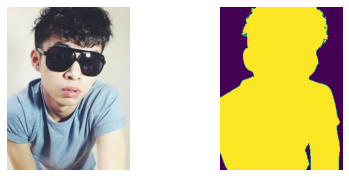

In [ ]:
idx = 0
show_idx_image(test_dataset, idx)

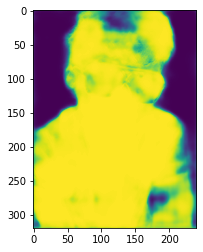

In [ ]:
res = net(test_dataset[idx][0].unsqueeze(0).cuda())[0].cpu().detach() 
res = torch.sigmoid(res).transpose(0, 1).transpose(1, 2).numpy().reshape(320, 240)
plt.imshow(res)

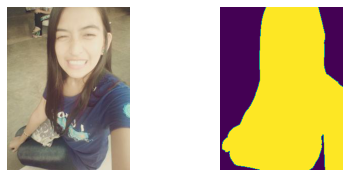

In [ ]:
idx = 3
show_idx_image(test_dataset, idx)

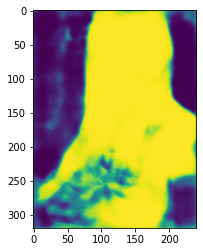

In [ ]:
res = net(test_dataset[idx][0].unsqueeze(0).cuda())[0].cpu().detach() 
res = torch.sigmoid(res).transpose(0, 1).transpose(1, 2).numpy().reshape(320, 240)
plt.imshow(res)

In [ ]:
net_1 = UNet()
if torch.cuda.is_available():
    net_1.cuda()
criterion = DiceLoss(reduction='mean')
test_criterion = DiceLoss(reduction='mean')
test_val_criterion = BCEWithLogitsLoss(reduction='mean')
optimizer = optim.SGD(net_1.parameters(), lr=1e-3, momentum=0.9)
optimize_net(30, net_1, train_data_loader, optimizer, criterion, test_criterion, test_val_criterion)

n_epoch: 0 time: 2.384185791015625e-06
[0.49] loss: 0.319
[0.99] loss: 0.259
[1] test_loss_1: 0.229, test_loss_2: 0.039
------------------------------
n_epoch: 1 time: 108.75703644752502
[0.49] loss: 0.258
[0.99] loss: 0.250
[2] test_loss_1: 0.279, test_loss_2: 0.039
------------------------------
n_epoch: 2 time: 220.95139479637146
[0.49] loss: 0.252
[0.99] loss: 0.255
[3] test_loss_1: 0.309, test_loss_2: 0.039
------------------------------
n_epoch: 3 time: 334.57106041908264
[0.49] loss: 0.255
[0.99] loss: 0.237
[4] test_loss_1: 0.331, test_loss_2: 0.039
------------------------------
n_epoch: 4 time: 449.14820528030396
[0.49] loss: 0.251
[0.99] loss: 0.253
[5] test_loss_1: 0.346, test_loss_2: 0.039
------------------------------
n_epoch: 5 time: 564.0143847465515
[0.49] loss: 0.254
[0.99] loss: 0.251
[6] test_loss_1: 0.358, test_loss_2: 0.039
------------------------------
n_epoch: 6 time: 678.7024812698364
[0.49] loss: 0.251
[0.99] loss: 0.250
[7] test_loss_1: 0.369, test_loss_2: 

Использование функции потерь DiceLoss показало плохие результаты. Как можно видеть, сеть не обучалась, тк ошибка на трейне не изменялась, а на тесте - сильно росла. На визуализированных изображениях видно, что сеть улавливает силуэт, однако не может вполне корректно выделить его на изображении.

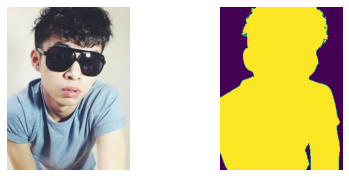

In [ ]:
idx = 0
show_idx_image(test_dataset, idx)

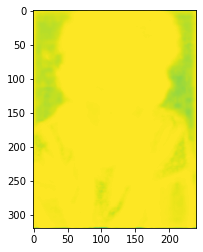

In [ ]:
res = net_1(test_dataset[idx][0].unsqueeze(0).cuda())[0].cpu().detach() 
res = torch.sigmoid(res).transpose(0, 1).transpose(1, 2).numpy().reshape(320, 240)
plt.imshow(res)

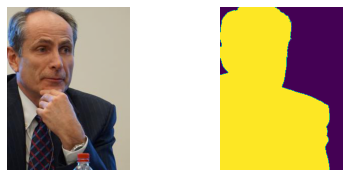

In [ ]:
idx = 49
show_idx_image(test_dataset, idx)

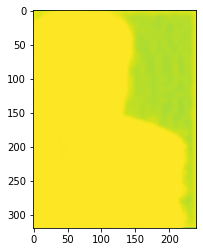

In [ ]:
res = net_1(test_dataset[idx][0].unsqueeze(0).cuda())[0].cpu().detach() 
res = torch.sigmoid(res).transpose(0, 1).transpose(1, 2).numpy().reshape(320, 240)
plt.imshow(res)

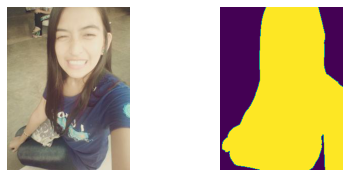

In [ ]:
idx = 3
show_idx_image(test_dataset, idx)

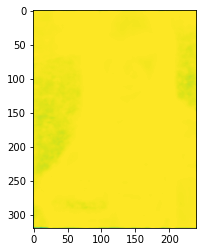

In [ ]:
res = net_1(test_dataset[idx][0].unsqueeze(0).cuda())[0].cpu().detach() 
res = torch.sigmoid(res).transpose(0, 1).transpose(1, 2).numpy().reshape(320, 240)
plt.imshow(res)

In [ ]:
def test_criterion(outputs, labels):
  alpha = beta = 0.5
  obj = DiceLoss(reduction='mean')
  obj_1 = BCEWithLogitsLoss(reduction='mean')
  return alpha * obj(outputs, labels) + beta * obj_1(outputs, labels) 

In [ ]:
net_2 = UNet()
if torch.cuda.is_available():
    net_2.cuda()
test_val_criterion = DiceLoss(reduction='mean')
optimizer = optim.SGD(net_2.parameters(), lr=1e-3, momentum=0.9)
optimize_net(30, net_2, train_data_loader, optimizer, criterion, criterion, test_val_criterion)

n_epoch: 0 time: 2.384185791015625e-06
[0.49] loss: 0.339
[0.99] loss: 0.254
[1] test_loss_1: 0.039, test_loss_2: 0.039
------------------------------
n_epoch: 1 time: 109.21369767189026
[0.49] loss: 0.250
[0.99] loss: 0.251
[2] test_loss_1: 0.039, test_loss_2: 0.039
------------------------------
n_epoch: 2 time: 221.503839969635
[0.49] loss: 0.255
[0.99] loss: 0.254
[3] test_loss_1: 0.039, test_loss_2: 0.039
------------------------------
n_epoch: 3 time: 335.15540599823
[0.49] loss: 0.247
[0.99] loss: 0.251
[4] test_loss_1: 0.039, test_loss_2: 0.039
------------------------------
n_epoch: 4 time: 449.3117005825043
[0.49] loss: 0.255
[0.99] loss: 0.246
[5] test_loss_1: 0.039, test_loss_2: 0.039
------------------------------
n_epoch: 5 time: 563.9114007949829
[0.49] loss: 0.240
[0.99] loss: 0.253
[6] test_loss_1: 0.039, test_loss_2: 0.039
------------------------------
n_epoch: 6 time: 678.8665506839752
[0.49] loss: 0.258
[0.99] loss: 0.246
[7] test_loss_1: 0.039, test_loss_2: 0.039


Использование выпуклой комбинации(рассматривались коэффициенты 0.5 и 0.5) дало результаты средние между работой обеих предыдущих сетей. Здесь сеть научилась явно выделять фон, однако такое определение силуэта человека, как при использовании только BCE, ей оказалось не под силу.

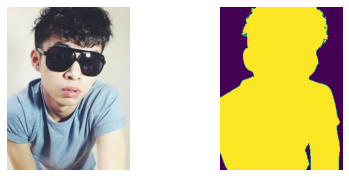

In [ ]:
idx = 0
show_idx_image(test_dataset, idx)

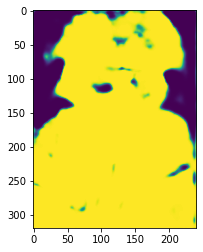

In [ ]:
res = net_2(test_dataset[idx][0].unsqueeze(0).cuda())[0].cpu().detach() 
res = torch.sigmoid(res).transpose(0, 1).transpose(1, 2).numpy().reshape(320, 240)
plt.imshow(res)

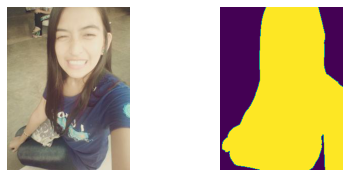

In [ ]:
idx = 3
show_idx_image(test_dataset, idx)

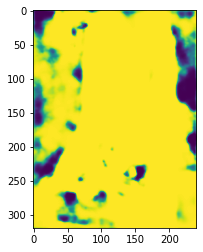

In [ ]:
res = net_2(test_dataset[idx][0].unsqueeze(0).cuda())[0].cpu().detach() 
res = torch.sigmoid(res).transpose(0, 1).transpose(1, 2).numpy().reshape(320, 240)
plt.imshow(res)

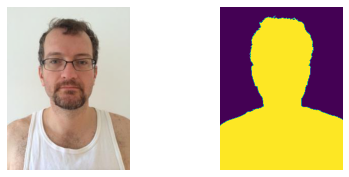

In [ ]:
idx = 8
show_idx_image(test_dataset, idx)

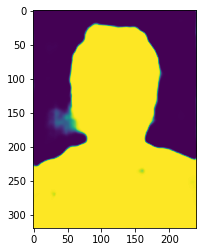

In [ ]:
res = net_2(test_dataset[idx][0].unsqueeze(0).cuda())[0].cpu().detach() 
res = torch.sigmoid(res).transpose(0, 1).transpose(1, 2).numpy().reshape(320, 240)
plt.imshow(res)

## LinkNet (3 балла)

Реализуйте архитектуру LinkNet с использованием энкодера, основанного на VGG13. Архитектура похожа на Unet, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

https://arxiv.org/pdf/1707.03718.pdf

In [ ]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        feature_extractor = vgg13(pretrained=pretrained).features
        for i in range(self.num_blocks):
            self.blocks.append(
                torch.nn.Sequential(*[feature_extractor[j]
                                      for j in range(i * 5, i * 5 + 4)]))

    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
            activations.append(x)
            if i != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations

In [ ]:
class DecoderBlock_1(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels, # здесь проихошли изменения
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )

    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.conv1(torch.add(left, x)) # здесь проихошли изменения
        #x = self.conv1(left + x)
        x = self.conv2(x)
        return x

In [ ]:
class Decoder_1(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock_1(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

In [ ]:
class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder_1(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

In [ ]:
net_3 = LinkNet()
if torch.cuda.is_available():
    net_3.cuda()
optimizer = optim.SGD(net_3.parameters(), lr=1e-3, momentum=0.9)
criterion = BCEWithLogitsLoss(reduction='mean')
test_criterion = BCEWithLogitsLoss(reduction='mean')
val_test_criterion = DiceLoss(reduction='mean')
optimize_net(30, net_3, train_data_loader, optimizer, criterion, test_criterion, val_test_criterion)

n_epoch: 0 time: 2.384185791015625e-06
[0.49] loss: 0.518
[0.99] loss: 0.309
[1] test_loss_1: 0.035, test_loss_2: 0.046
------------------------------
n_epoch: 1 time: 52.218435764312744
[0.49] loss: 0.231
[0.99] loss: 0.208
[2] test_loss_1: 0.031, test_loss_2: 0.037
------------------------------
n_epoch: 2 time: 104.5343005657196
[0.49] loss: 0.199
[0.99] loss: 0.195
[3] test_loss_1: 0.029, test_loss_2: 0.033
------------------------------
n_epoch: 3 time: 156.5337941646576
[0.49] loss: 0.180
[0.99] loss: 0.168
[4] test_loss_1: 0.026, test_loss_2: 0.035
------------------------------
n_epoch: 4 time: 208.70475220680237
[0.49] loss: 0.168
[0.99] loss: 0.164
[5] test_loss_1: 0.027, test_loss_2: 0.033
------------------------------
n_epoch: 5 time: 260.9028913974762
[0.49] loss: 0.166
[0.99] loss: 0.162
[6] test_loss_1: 0.026, test_loss_2: 0.030
------------------------------
n_epoch: 6 time: 313.0361421108246
[0.49] loss: 0.155
[0.99] loss: 0.158
[7] test_loss_1: 0.027, test_loss_2: 0.

Linknet обучается быстрее. Резльутаты демонстрирует сравнимые по качеству (даже в некоторых местах и более качественные).

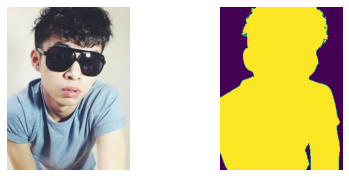

In [ ]:
show_idx_image(test_dataset, 0)
idx = 0

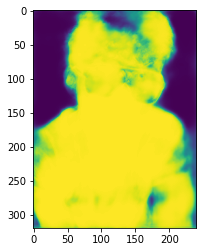

In [ ]:
res = net_3(test_dataset[idx][0].unsqueeze(0).cuda())[0].cpu().detach() 
res = torch.sigmoid(res).transpose(0, 1).transpose(1, 2).numpy().reshape(320, 240)
plt.imshow(res)

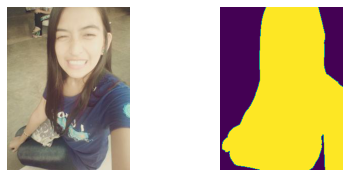

In [ ]:
show_idx_image(test_dataset, 3)
idx = 3

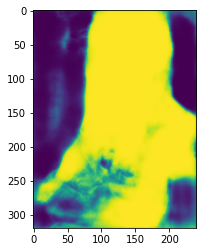

In [ ]:
res = net_3(test_dataset[idx][0].unsqueeze(0).cuda())[0].cpu().detach() 
res = torch.sigmoid(res).transpose(0, 1).transpose(1, 2).numpy().reshape(320, 240)
plt.imshow(res)

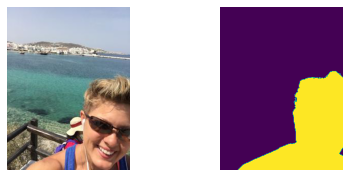

In [ ]:
show_idx_image(test_dataset, 10)
idx = 10

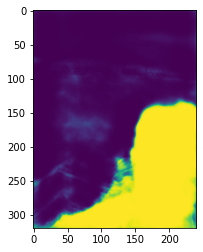

In [ ]:
res = net_3(test_dataset[idx][0].unsqueeze(0).cuda())[0].cpu().detach() 
res = torch.sigmoid(res).transpose(0, 1).transpose(1, 2).numpy().reshape(320, 240)
plt.imshow(res)

In [ ]:
net_4 = UNet()
if torch.cuda.is_available():
    net_4.cuda()
criterion = DiceLoss(reduction='mean')
test_criterion = DiceLoss(reduction='mean')
test_val_criterion = BCEWithLogitsLoss(reduction='mean')
optimizer = optim.SGD(net_4.parameters(), lr=1e-3, momentum=0.9)
optimize_net(30, net_4, train_data_loader, optimizer, criterion, test_criterion, test_val_criterion)

n_epoch: 0
[0.49] loss: 0.321
[0.99] loss: 0.246
[1] test_loss_1: 0.281, test_loss_2: 0.039
------------------------------
n_epoch: 1
[0.49] loss: 0.252
[0.99] loss: 0.248
[2] test_loss_1: 0.331, test_loss_2: 0.039
------------------------------
n_epoch: 2
[0.49] loss: 0.253
[0.99] loss: 0.252
[3] test_loss_1: 0.349, test_loss_2: 0.039
------------------------------
n_epoch: 3
[0.49] loss: 0.255
[0.99] loss: 0.248
[4] test_loss_1: 0.361, test_loss_2: 0.039
------------------------------
n_epoch: 4
[0.49] loss: 0.240
[0.99] loss: 0.250
[5] test_loss_1: 0.369, test_loss_2: 0.039
------------------------------
n_epoch: 5
[0.49] loss: 0.245
[0.99] loss: 0.260
[6] test_loss_1: 0.368, test_loss_2: 0.039
------------------------------
n_epoch: 6
[0.49] loss: 0.252
[0.99] loss: 0.243
[7] test_loss_1: 0.365, test_loss_2: 0.039
------------------------------
n_epoch: 7
[0.49] loss: 0.249
[0.99] loss: 0.243
[8] test_loss_1: 0.355, test_loss_2: 0.038
------------------------------
n_epoch: 8
[0.49

Удивительно, но обучение LinkNet на DiceLoss тоже показало вполне приемлемые результаты. Конечно, хуже, чем результаты обеих сетей при использовании BCE, но все же человек на изображениях ищется точно, хоть и из него вырезаются некоторые детали.

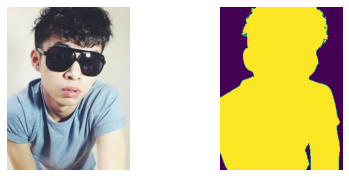

In [ ]:
show_idx_image(test_dataset, 0)
idx = 0

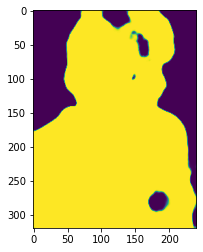

In [ ]:
res = net_4(test_dataset[idx][0].unsqueeze(0).cuda())[0].cpu().detach() 
res = torch.sigmoid(res).transpose(0, 1).transpose(1, 2).numpy().reshape(320, 240)
plt.imshow(res)

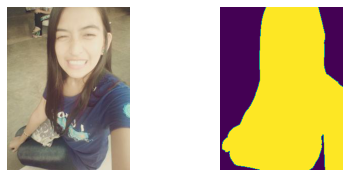

In [ ]:
show_idx_image(test_dataset, 3)
idx = 3

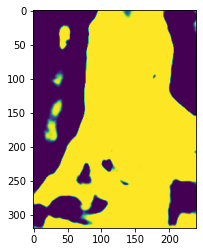

In [ ]:
res = net_4(test_dataset[idx][0].unsqueeze(0).cuda())[0].cpu().detach() 
res = torch.sigmoid(res).transpose(0, 1).transpose(1, 2).numpy().reshape(320, 240)
plt.imshow(res)

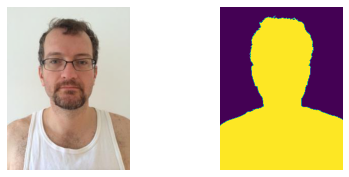

In [ ]:
show_idx_image(test_dataset, 8)
idx = 8

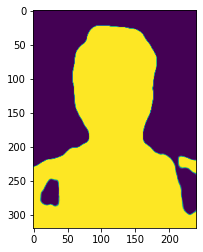

In [ ]:
res = net_4(test_dataset[idx][0].unsqueeze(0).cuda())[0].cpu().detach() 
res = torch.sigmoid(res).transpose(0, 1).transpose(1, 2).numpy().reshape(320, 240)
plt.imshow(res)

In [ ]:
def test_criterion_1(outputs, labels):
  alpha = 0.1
  beta = 0.9
  obj = DiceLoss(reduction='mean')
  obj_1 = BCEWithLogitsLoss(reduction='mean')
  return alpha * obj(outputs, labels) + beta * obj_1(outputs, labels) 

Для изучения качества работы сети, обученной на выпуклой комбинации лоссов, используем теперь коэфициенты 0.1 и 0.9.

In [ ]:
net_5 = UNet()
if torch.cuda.is_available():
    net_5.cuda()
criterion = test_criterion_1
test_criterion = test_criterion_1
test_val_criterion = BCEWithLogitsLoss(reduction='mean')
optimizer = optim.SGD(net_5.parameters(), lr=1e-3, momentum=0.9)
optimize_net(30, net_5, train_data_loader, optimizer, criterion, test_criterion, test_val_criterion)

Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /root/.cache/torch/checkpoints/vgg13-c768596a.pth



n_epoch: 0 time: 2.1457672119140625e-06
[0.49] loss: 0.549
[0.99] loss: 0.426
[1] test_loss_1: 0.071, test_loss_2: 0.069
------------------------------
n_epoch: 1 time: 58.00475811958313
[0.49] loss: 0.303
[0.99] loss: 0.228
[2] test_loss_1: 0.040, test_loss_2: 0.039
------------------------------
n_epoch: 2 time: 115.70691585540771
[0.49] loss: 0.205
[0.99] loss: 0.192
[3] test_loss_1: 0.035, test_loss_2: 0.034
------------------------------
n_epoch: 3 time: 173.45699095726013
[0.49] loss: 0.182
[0.99] loss: 0.183
[4] test_loss_1: 0.033, test_loss_2: 0.032
------------------------------
n_epoch: 4 time: 231.1328547000885
[0.49] loss: 0.175
[0.99] loss: 0.168
[5] test_loss_1: 0.031, test_loss_2: 0.030
------------------------------
n_epoch: 5 time: 288.56048250198364
[0.49] loss: 0.172
[0.99] loss: 0.157
[6] test_loss_1: 0.031, test_loss_2: 0.030
------------------------------
n_epoch: 6 time: 346.14298129081726
[0.49] loss: 0.153
[0.99] loss: 0.155
[7] test_loss_1: 0.040, test_loss_2

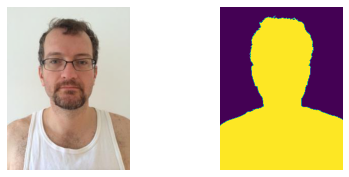

In [ ]:
show_idx_image(test_dataset, 8)
idx = 8

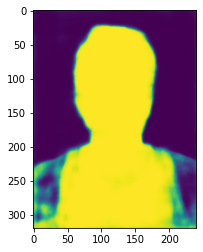

In [ ]:
res_1 = net_5(test_dataset[idx][0].unsqueeze(0).cuda())[0].cpu().detach() 
res_1 = torch.sigmoid(res_1).transpose(0, 1).transpose(1, 2).numpy().reshape(320, 240)
plt.imshow(res_1)

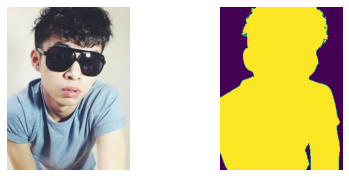

In [ ]:
show_idx_image(test_dataset, 0)
idx = 0

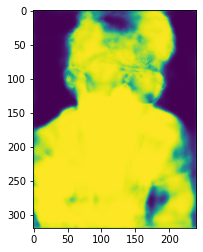

In [ ]:
res_2 = net_5(test_dataset[idx][0].unsqueeze(0).cuda())[0].cpu().detach() 
res_2 = torch.sigmoid(res_2).transpose(0, 1).transpose(1, 2).numpy().reshape(320, 240)
plt.imshow(res_2)

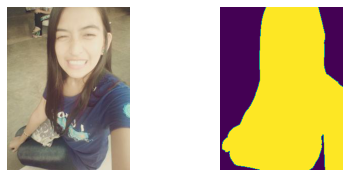

In [ ]:
show_idx_image(test_dataset, 3)
idx = 3

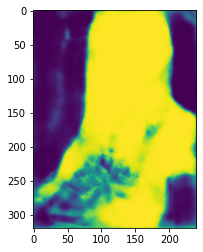

In [ ]:
res = net_5(test_dataset[idx][0].unsqueeze(0).cuda())[0].cpu().detach() 
res = torch.sigmoid(res).transpose(0, 1).transpose(1, 2).numpy().reshape(320, 240)
plt.imshow(res)

При использовании взвешенной суммы с большим коэффициентом при функции потерь ВСЕ время обучения уменьшается, а качество работы больше в сравнении с использованием просто функции потерь Dice. Кроме того, время обучения одной эпохи так же немного изменяется с выбором другого критерия качества: для ВСЕ - быстрее всего.

Обучите LinkNet. Сравните LinkNet и Unet по качеству и скорости работы. Сделайте выводы. 
В целом, LinkNet показал лучшие результаты и более быстрое время работы(сложить легче, чем конкатенировать). Судя по всему, исторически данный метод появился немного позже и смог исправить ошибки своего предшественника.

## Бонус: постобработка изображений (1 балл)

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля https://scikit-image.org/docs/dev/api/skimage.morphology.html). 

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

In [ ]:
from skimage.morphology import area_closing, remove_small_objects, thin, closing, dilation, erosion
from skimage.filters import gaussian, median

In [ ]:
def better_pict(img):
  img = remove_small_objects(img, 64)

  img = gaussian(img, 0.7)
  img = erosion(img)
  img = dilation(img)

  img = area_opening(img)
  img = median(img)

  return img

+ примеры работы

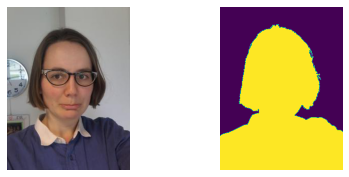

In [ ]:
idx = 31 #5, 19, 20, 21, 24, 31!!!!!!!, 37, 43, 54
show_idx_image(test_dataset, idx)

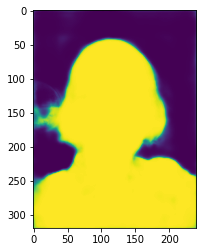

In [ ]:
res = net_5(test_dataset[idx][0].unsqueeze(0).cuda())[0].cpu().detach() 
res = torch.sigmoid(res).transpose(0, 1).transpose(1, 2).numpy().reshape(320, 240)
plt.imshow(res)

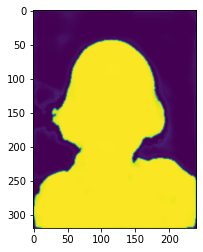

In [ ]:
plt.imshow(better_pict((np.array(res.tolist()) * 255).astype(int)))

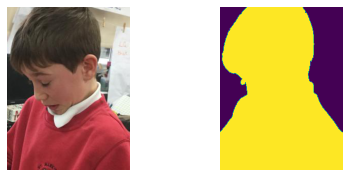

In [ ]:
idx = 20 #5, 19, 20, 21, 24, 31!!!!!!!, 37, 43, 54
show_idx_image(test_dataset, idx)

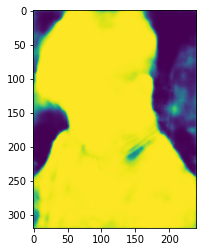

In [ ]:
res = net_5(test_dataset[idx][0].unsqueeze(0).cuda())[0].cpu().detach() 
res = torch.sigmoid(res).transpose(0, 1).transpose(1, 2).numpy().reshape(320, 240)
plt.imshow(res)

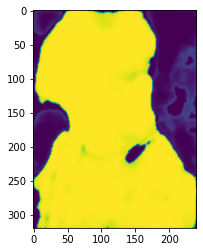

In [ ]:
plt.imshow(better_pict((np.array(res.tolist()) * 255).astype(int)))

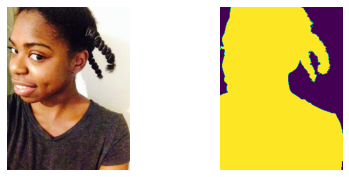

In [ ]:
idx = 37 #5, 19, 20, 21, 24, 31!!!!!!!, 37, 43, 54
show_idx_image(test_dataset, idx)

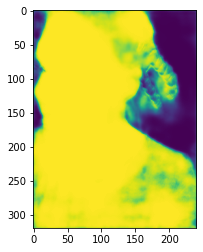

In [ ]:
res = net_5(test_dataset[idx][0].unsqueeze(0).cuda())[0].cpu().detach() 
res = torch.sigmoid(res).transpose(0, 1).transpose(1, 2).numpy().reshape(320, 240)
plt.imshow(res)

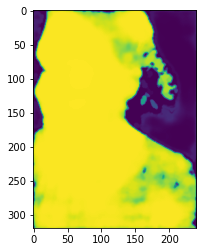

In [ ]:
plt.imshow(better_pict((np.array(res.tolist()) * 255).astype(int)))

## Бонус: существенное улучшение качества (2 балла)

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.